<font size="5"><b>Lecture 04: Morphology and Segmentation (exercises)</b></font>

# EX: analyze an infrared image of a lava lake

## open image

<div class="alert alert-success">
The image is a radiometric image of Mount Nyiragongo's (D.R.C) active lava lake, acquired with a FLIR camera operating in the infrared 7.5–14 μm spectral range, and returning temperatures in Kelvin [<a href="https://www.sciencedirect.com/science/article/pii/S0012821X18304631?via%3Dihub" target="_blank">ref</a>]. The image and associated metadata are saved as a .MAT file.<br>
<br>
Use the <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html" target="_blank">scipy.io.loadmat()</a> function to open the .MAT file. The returned object is a Python dictionary. The image is stored in a key defined by the frame number (e.g., "frame_320")<br>
</div>

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

In [2]:
f_mat = 'images/FLIR_Nyiragongo-rim_20160421T105412_frame320.MAT'

img_dict = loadmat(f_mat)

In [3]:
img_dict.keys()

dict_keys(['frame_320', 'frame_320_DateTime', 'frame_320_ObjectParam', 'frame_320_Scaling', 'frame_320_FrameInfo'])

In [4]:
img_time = img_dict['frame_320_DateTime']
img_time

array([[2016.,    4.,   21.,   10.,   54.,   12.,  599.]])

In [5]:
img = img_dict['frame_320']

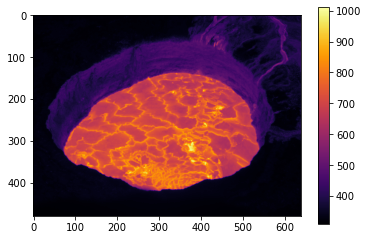

In [6]:
plt.imshow(img, cmap='inferno')
plt.colorbar()

#plt.imshow(img, cmap=plt.cm.inferno)

## segment lake from background

<div class="alert alert-success">
    <b>1.</b> Crop the image to focus on the lava lake.<br>
    <br>
    <b>2.</b> Plot the histogram of the cropped image. Based on the temperature distribution, isolate the pixels corresponding to the lava lake.<br>
    <u>Tip</u>: use <a href="https://numpy.org/doc/stable/reference/generated/numpy.where.html" target="_blank">numpy.where()</a> function to generate a new array, keeping the temperatures for the pixels corresponding to the lake, and attributing "np.nan" values elsewhere.<br>
</div>

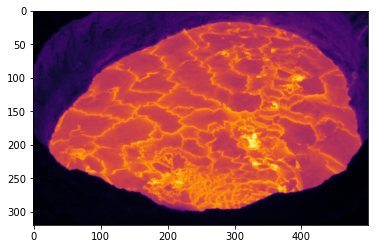

In [7]:
img_c = img[120:440, 50:550]

plt.imshow(img_c, cmap='inferno')

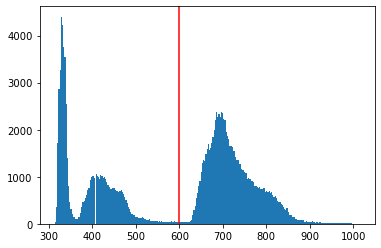

In [8]:
plt.hist(img_c.ravel(), bins=255);

plt.axvline(x=600, color='r')

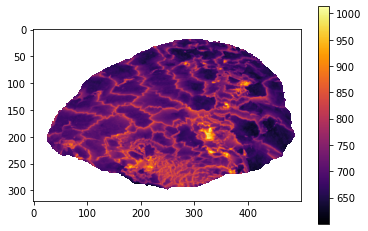

In [9]:
img_l = np.where(img_c>600, img_c, np.nan)

plt.imshow(img_l, cmap='inferno')
plt.colorbar()

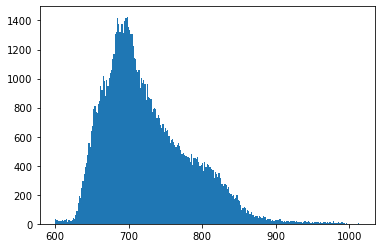

In [10]:
plt.hist(img_l.ravel(), bins=255);

## segment plates using histogram thresholding
The lake surface consists of a mosaic of dark (cool) crustal plates, separated by narrow incandescent (hot) cracks. The goal of this section is to segment the plates from the cracks.

### try global thresholding

<div class="alert alert-success">
Play around with temperature thresholds to try to isolate the cold plates from the hot cracks (binarize image).<br>
Try setting threshold values manually. Try <a href="https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_otsu" target="_blank">Otsu's threshold</a>. Can you reach satisfying results?
</div>

In [11]:
thresh = 700

#img_b = np.where(img_c>thresh, 1, 0)
img_b = img_c>thresh

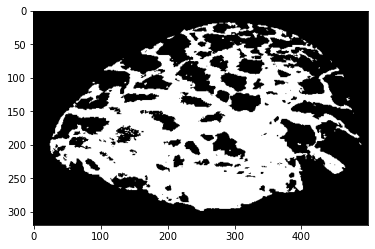

In [12]:
plt.imshow(img_b, cmap='gray')

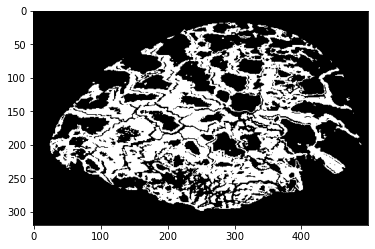

In [13]:
thresh1 = 700
thresh2 = 800

img_b = np.where((img_c>thresh1) & (img_c<thresh2), 1, 0)

plt.imshow(img_b, cmap='gray')

In [14]:
from skimage import filters

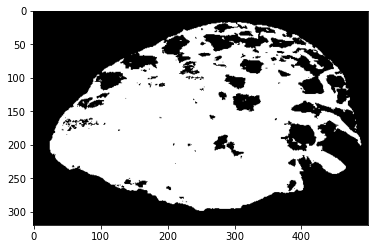

In [15]:
img_c2 = np.where(img_c>600, img_c, 600)

thresh_otsu = filters.threshold_otsu(img_c2)

img_b = img_c > thresh_otsu

plt.imshow(img_b, cmap='gray')

### try local thresholding

<div class="alert alert-success">
    The plates display a relatively wide range of temperatures, making it difficult to seperate them from the hot cracks using a single global temperature threshold. <u>Local thresholding</u> (a.k.a. adaptive thresholding) can be useful to overcome this, as multiple thresholds are calulated in small regions surrounding each pixel.<br>
    <br>
    <u>Tip</u>: you can use scikit-image's <a href="https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_local" target="_blank">filters.threshold_local()</a> to test this.<br>
    <u>Tip</u>: once the image has been binarized with local thresholds, you can keep only the lake like you did in section 1.1.
</div>

In [16]:
block_size = 31 #31

thresh_loc = filters.threshold_local(img_c, block_size=block_size)

In [17]:
img_b = img_c > thresh_loc

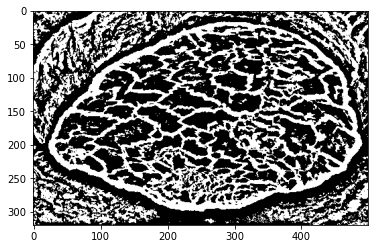

In [18]:
plt.imshow(img_b, cmap='gray')

In [19]:
img_b2 = np.where(img_c>600, img_b, 0)

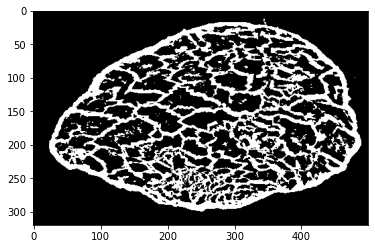

In [20]:
plt.imshow(img_b2, cmap='gray')

### clean image using mathematical morphology

<div class="alert alert-success">
    Mathematical morphology can be used used "clean" your image, by removing small undesired regions (e.g., "false cracks").<br>
    Explore scikit-image's <a href="https://scikit-image.org/docs/dev/api/skimage.morphology.html" target="_blank">morphology</a> module to find a function that suits your needs.<br>
    <br>
    <u>Tip</u>: consider removing bright structures smaller than an area threshold.
</div>

In [21]:
from skimage import morphology

img_b2m = morphology.area_opening(img_b2, area_threshold=104)

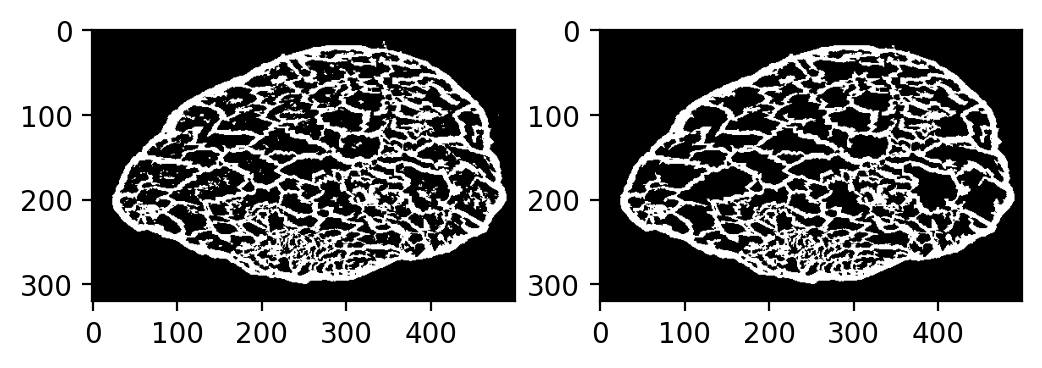

In [22]:
plt.figure(dpi=200)

plt.subplot(121)
plt.imshow(img_b2, cmap='gray')

plt.subplot(122)
plt.imshow(img_b2m, cmap='gray')

### label isolated image regions

<div class="alert alert-success">
    Once you are satisfied with your binarized image, you are ready to "label" the connected regions.<br>
    You can use scikit-image's <a href="https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label" target="_blank">measure.label()</a> function. (or <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.label.html" target="_blank">scipy.ndimage.label()</a>).<br>
    <br>
    <u>Tip</u>: these functions will label pixels different than the background, which by default is defined as pixels with value 0. So adjust the background parameter to your image (or adapt your image to the function ;)
</div>

In [23]:
from skimage import measure

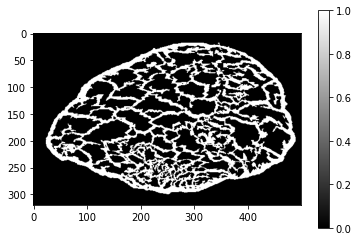

In [24]:
plt.imshow(img_b2m, cmap='gray')
plt.colorbar()

In [25]:
img_labels = measure.label(img_b2m, background=1)

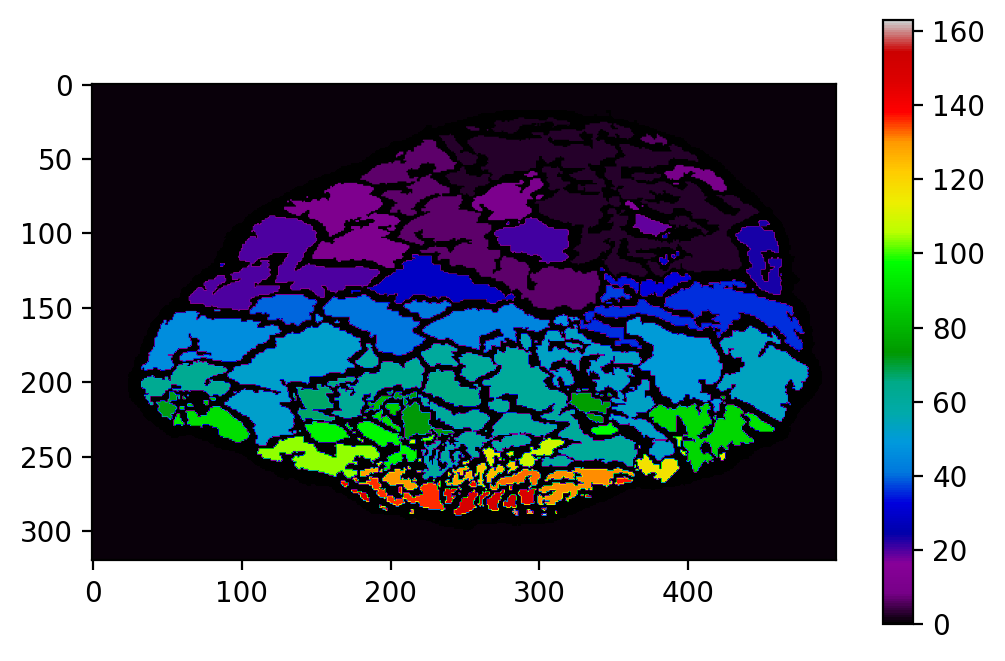

In [28]:
plt.figure(dpi=200)
plt.imshow(img_labels, cmap=plt.cm.nipy_spectral)
plt.colorbar()

### analyze plates

<div class="alert alert-success">
    Scikit-image provides a convenient <a href="https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops" target="_blank">measure.regionprops()</a> function to analyze basic parameters from the labeled image components.<br>
    <br>
    <b>1.</b> Use the function to get the plates's centroids, and plot them on top of your labeled image.
</div>

In [ ]:
# --- measure properties
regions = measure.regionprops(img_labels)

In [ ]:
p = regions[0]

list(p)

p.area

In [ ]:
plt.figure(dpi=200)
#plt.imshow(img_labels_rgb)
plt.imshow(img_c, cmap='gray')
plt.contour(img_labels, [.5], linewidths=1, colors='k')

for props in regions:
    y0, x0 = props.centroid

    plt.plot(x0, y0, 'w.', markersize=2)
    plt.text(x0, y0, props.label, fontsize=5)

<div class="alert alert-success">
    <b>2.</b> Use scikit-image's <a href="https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops_table" target="_blank">measure.regionprops_table()</a> function to return the label properties as a pandas table.<br> 
    Plot a histogram of the plate's area.
</div>

## (optional) experiment "flood fill" segmentation

<div class="alert alert-success">
You can plan around with scikit-image's <a href="https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_floodfill.html#sphx-glr-auto-examples-segmentation-plot-floodfill-py" target="_blank">flood_fill()</a> algorithm. By selecting a seed point (= pixel where flooding start), you can segment neighboring pixels sharing the same temperatures (within a selected temperature tolerance).<br>
</div>